In [19]:
from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
import numpy as np

The model will be downloaded from the HuggingFace hub if it wasn't found in the passed cache directory (default=```'.cache'```).

In [20]:
emulator = TransformerPayne.download()

/Users/tr/repos/transformer_payne/src/transformer_payne/transformer_payne.py:122: UserWarning: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte Downloading the model from HuggingFace.
  warnings.warn(str(e) + " Downloading the model from HuggingFace.")


This is all you need! You can now work with spectra by passing in the:
- logarithms of wavelengths in [log($\AA$)]
- spectral parameter values (refer to ```emulator.parameter_names```)
- $\mu$ - cosine of the angle between the radius and the line-of-sight

In [21]:
wave = np.linspace(4800, 4900, 10000)
spectral_parameters = emulator.solar_parameters # here we use solar parameters shipped with the model
mu = 1.0

# First call is longer as a function gets compiled
%time y = emulator(np.log10(wave), mu, spectral_parameters)

CPU times: user 11.4 s, sys: 941 ms, total: 12.3 s
Wall time: 8.65 s


In [22]:
# now when the function is compiled, for given log_wave.shape then the function is faster
# Changing the length of the wave vector will require recompilation
%time y = emulator(np.log10(wave), mu, spectral_parameters)

CPU times: user 4.84 s, sys: 431 ms, total: 5.27 s
Wall time: 1.35 s


The ```TransformerPayne``` emulator return a 2D array - containing an intensity and continuum (intensity without lines).

If you want to take an intensity, continuum or compute normalised intensity run:

In [23]:
intensity = y[:,0]
continuum = y[:,1]
normalized_intensity = intensity / continuum

And now let take a look at our results:

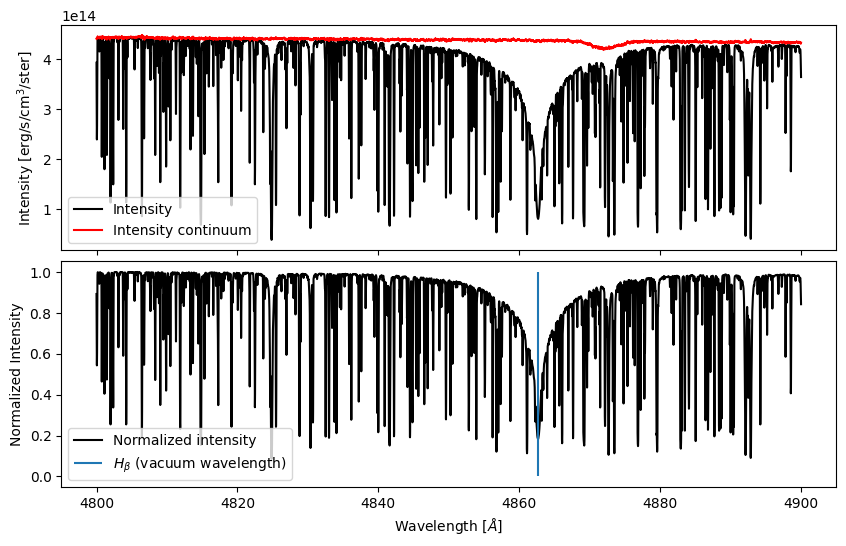

In [51]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
axs[0].plot(wave, intensity, color='black', label='Intensity')
axs[0].plot(wave, continuum, color='red', label='Intensity continuum')
axs[1].plot(wave, normalized_intensity, label="Normalized intensity", color='black')
axs[1].vlines(4862.721, 0, 1, color='C0', label=r'$H_\beta$ (vacuum wavelength)')  # Using raw string for LaTeX
axs[1].set_xlabel("Wavelength [$\AA$]")  # Corrected to set xlabel on the second subplot
axs[0].set_ylabel("Intensity [erg/s/cm$^3$/ster]")
axs[1].set_ylabel("Normalized Intensity")
axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
plt.subplots_adjust(hspace=0.05)